In [1]:
# these are the Classes used from the Shapely library
# - https://shapely.readthedocs.io/en/stable/manual.html
from shapely.geometry import Point
from shapely.geometry import Polygon
from shapely.geometry import LineString
from shapely.geometry import LinearRing

# these are the different cap styles for the "buffer" function
from shapely.geometry import CAP_STYLE, JOIN_STYLE

# plotting
import matplotlib.pyplot as plt

# arrays and math
import numpy as np

# image processing
import cv2

# opening files and paths
import os


from shapely_conversion import convert
from shapely_utilities import *

import spiral as S
from spiral import calculate_point, calculate_point_contour

import fermat_spiral as FS

# optimization module
from optimization import optimization

In [2]:
'''
Plot a single path
'''
def plot_path(path, color=None):
    
    X = []
    Y = []

    for p in path:
        X.append(p[0])
        Y.append(p[1])
        
    plt.plot(X,Y,c=color)


'''
Plot a list of paths
'''
def plot_recursive_path(total_path, color=None):
    
    rest = []
    
    for path in total_path:
        if type(path) is list:
            plot_path(path, color)
        else:
            rest.append(path)
            
    plot_path(rest, color)

In [3]:
# this generates the total path without combining the paths
def generate_total_path(result, distance):
    
    total_path = []
    contour_family = []
    
    # loop through each value in the result
    for branch in result:
        if type(branch) is list:  
            total_path.extend(generate_total_path(branch, distance))
        else:
            contour_family.append(branch)

    results = S.execute(contour_family, distance)

    total_path.append(results)

    return total_path

In [4]:
# this generates the total path without combining the paths
def generate_total_pathf(result, distance):
    
    total_path = []
    contour_family = []
    
    # loop through each value in the result
    for branch in result:
        if type(branch) is list:  
            total_path.extend(generate_total_pathf(branch, distance))
        else:
            contour_family.append(branch)

    s_path = S.execute(contour_family, distance)
            
    results = FS.convert_fermat(s_path,distance)

    total_path.append(results)

    return total_path

In [5]:
# this creates a fermat path recursively from a tree of Polygon objects
def generate_fermat_path(result, distance):
    
    branches = []

    contour_family = []

    # loop through each node or branch in the tree
    for node in result:
        
        # if the result node is a branch, recursively call this function on it
        if type(node) is list:
            branches.append(generate_fermat_path(node, distance))
        # if the result node is not a branch, add it to the contour family
        else:
            contour_family.append(node)

    # generate the fermat spiral from the root and the branches
    root = FS.fermat_path(contour_family, distance,debug=False)

    # combine the root and the branches
    if root:
        return FS.combine_paths(root, branches, distance)
    
    # if there is no root (not sure how this happens but it does) - just return the branches?
    else:
        return branches

In [6]:
# execute runs the path function "fnc" on an image
# - use this to generate the path from an image
def execute(image, distance, fnc, simplify=True, optimize=False, optimize_local=True, opt_reg=1, opt_smh=200, opt_spacing=1):
    
    total_path = []
    
    # create the polygons from the image
    polygons = convert(image, approximation = cv2.CHAIN_APPROX_SIMPLE)
        
    # each individual polygon should be a separate distinct polygon in the image
    for polygon in polygons:
        
        # simplify the polygon to remove excess points - this helps with processing
        if simplify:
            polygon = polygon.simplify(distance/2)
        
        # generate the distance transform for the polygon
        result = distance_transform(polygon, -distance)
        
        # optimize each contour locally
        if optimize and optimize_local:
            for i in range(len(result)):
                result[i] = optimization(result[i], opt_reg, opt_smh, opt_spacing, optimize_local)
        
        # if there is a result, run the path generation function on the result
        if result:
            total_path.extend(fnc(result, distance))
            
    # optimize output path globally
    if optimize and not optimize_local:
        total_path = optimization(total_path, opt_reg, opt_smh, opt_spacing, optimize_local)
    
    return total_path

<IPython.core.display.Javascript object>


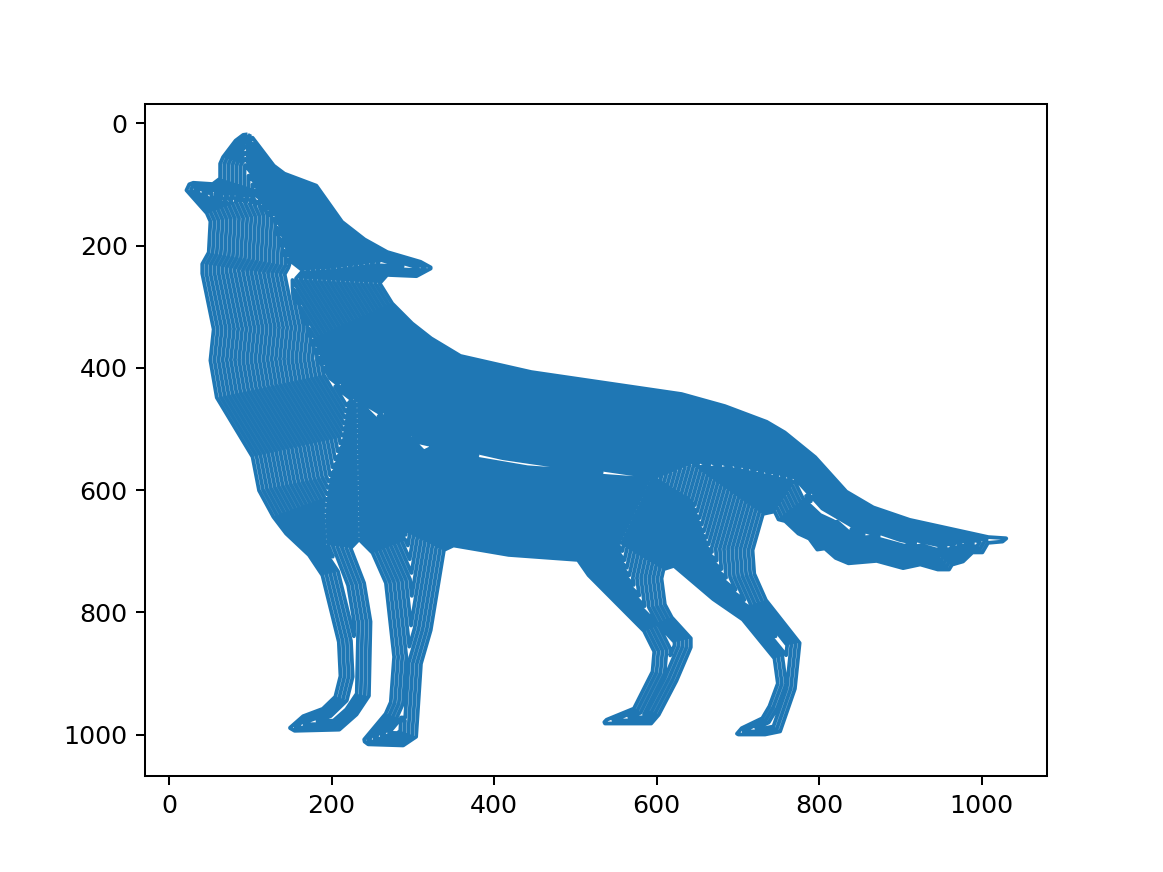

Wall time: 1.11 s


In [18]:
%%time
%matplotlib notebook
'''
This cell runs the complete pipeline from image to CFS output
'''

# distance in between each contour
distance = 5

# filename of image to process
filename = 'files/wolf.png'

# image should be in binary format
image = cv2.imread(filename,0)

# generate the un-connected fermat spiral output
# settings: simplify - True, optimize - False (flip this to true to see effect), optimize locally - True
#           penalize points for moving away from their original position: 1
#           penalize points for violating mid-point scheme: 5
#           spacing penalization is not implemented yet. The last term means nothing for now
results = execute(image, distance, generate_fermat_path, True, False, True, 1, 5, 1)
# plot and show the path
plot_recursive_path(results)
plt.gca().invert_yaxis()
plt.show()

In [8]:
LineString(results).is_simple

True

In [9]:
# helper function to display the format of the "result" tree
# - the "result" tree is the representation of the distance transform 
# - EX: A tree of "['X','X','X', ['X',['X','X'], ['X']], ['X']]" has...
# 1. Three successive outer contours (no branches)
# 2. A branch with a single contour with a depth-2 branch and a depth-1 branch
# 3. A branch with a single contour

# TODO there is probably a better way to set up the trees in this scenario
def simplify_tree(result):
    
    root = []
    output = []
    for b in result:
        if type(b) is list:
            output.append(simplify_tree(b))
            
    return ["X"] + output

In [10]:
# GCODE generation
# - this is used for converting the path into GCODE for the drawbot
# - applies an offset to each XY coordinate to avoid triggering the home flags repeatedly

x_offset = 2
y_offset = 2

# move the drawbot to a point
def command_move(p):
    return "G01 X" + str(p[0]+x_offset) + " Y" + str(p[1]+y_offset) + ";\n"

# move the pen up (drawbot specific)
def command_up():
    return "G01 Z0.5;\n"

# move the pen down (drawbot specific)
def command_down():
    return "G01 Z8.0;\n"

In [11]:
# GCODE generation
# - this takes the total path and creates a string of GCODE commands to follow the path
# - the expected input is a list of paths --> a single path should be in a list
def gcode(total_path, filename):
    
    # header function - home machine
    output = "G28 Z;\n"
    output += command_up()
    output += "G28 X Y;\n\n";
    
    for path in total_path:
        
        # move to p0
        output += command_move(path[0])
        
        # pen down
        output += command_down()
        
        # trace the path
        for p in path[1:]:
            output += command_move(p)
            
        # pen up
        output += command_up()
    
    # home machine
    output += "G28;\n"
    
    # print the number of commands
    print(len(output))
    
    # write the code to a gcode file
    f = open(filename, "w")
    f.write(output)
    f.close()
    
    # return the string (for debugging, not really needed)
    return output

In [12]:
def remove_short_paths(temp_path, length=20):
    
    clean_path = []
    
    for path in temp_path:
        
        if LineString(path).length > length:
            clean_path.append(path)
    
    return clean_path

In [13]:
'''
BACKUP CODE
'''
raise

# this combines the root and branches path
def combine_paths_backup(root, branches, dis):
        
    root_ls = LineString(root)
        
    # find the start and end points of the root
    for b in branches:

        if not b:
            continue
        
        s1 = Point(b[0])
        e1 = Point(b[-1])
        
        s2 = Point(b[1])
        e2 = Point(b[-2])
        
        
        # extend the endpoints out of the spiral
        s3 = extend_line(s2,s1,dis*1)
        e3 = extend_line(e2,e1,dis*1)
        
        
        # compute the end point connection
        ds1 = root_ls.project(s3)
        ds2 = root_ls.project(e3)        
        
        if ds1 == 0:  # cut the root at ds2

            # find the end point to add to the list
            end_point = root_ls.interpolate(ds2)
            ls1_list = []
            ls2_list = list(root_ls.coords)[1:] # drop the first point   
        elif ds2 == 0:  # cut the root at ds2

            # find the end point to add to the list
            end_point = root_ls.interpolate(ds2)
            ls1_list = list(root_ls.coords)
            ls2_list = []
        elif ds1 == root_ls.length:
            # cut the root at ds2
            ls1, ls2 = cut(root_ls, ds1-dis)    
            
            # find the end point to add to the list
            end_point = root_ls.interpolate(ds1)
            ls1_list = list(ls1.coords)
            ls2_list = list(ls2.coords)[1:] # drop the first point   
        
        # if the start is the first cut
        elif ds1 < ds2:
            
            # cut the root at the start point
            ls1, ls2 = cut(root_ls, ds1)
            
            # find the end point to add to the list
            end_point = root_ls.interpolate(ds2)
            ls1_list = list(ls1.coords)
            ls2_list = list(ls2.coords)[1:] # drop the first point   
        else:
            # cut the root at ds2
            ls1, ls2 = cut(root_ls, ds2)    
            
            # find the end point to add to the list
            end_point = root_ls.interpolate(ds1)
        
        
            ls1_list = list(ls1.coords)
            ls2_list = list(ls2.coords)[1:] # drop the first point        
        
        if ds1 < ds2:
            new_list = ls1_list + b + [end_point] + ls2_list
        else:
            new_list = ls1_list + b[::-1] + [end_point] + ls2_list        
        
        root_ls = LineString(new_list)
        
    return list(root_ls.coords)

RuntimeError: No active exception to reraise

In [ ]:
'''
BACKUP CODE
'''
raise

def calculate_break(path, start, distance):

    dis = 0
    
    while dis <= distance:
        _,path = cut(path,distance)
        
        dis = path.project(start)
    
    return path.interpolate(dis)
    

def point_distance(p1,p2):
    return np.sqrt((p1.x-p2.x)**2+(p1.y-p2.y)**2)
    

def get_inner_point(path, reroute, distance):
    
    _, spiral = cut(path, distance)

    # while the projection is the end of the spiral, return
    while spiral.project(reroute) == 0:
        _, spiral = cut(spiral, distance)

    point = spiral.interpolate(spiral.project(reroute))
    
    return point
    
    
def center_inner(center, p2, distance):
    # reroute is the end of the spiral
    reroute = Point(p2.coords[0])

    # cut the center away from the next start
    end = calculate_end(center, Point(p2.coords[0]), distance)

    center, _ = cut(center, center.project(end))

    return center
    

# get the point a distance "upstream" of the point on the path
# - this is not a projection distance, but a straightline distance
def calculate_reroute(path, point, radius):
    
    buff = point.buffer(radius).exterior
        
    path,_ = cut(path, path.project(point))
        
    result = path.intersection(buff)
    
    if result.type == "Point":
        return result
    elif result.type == "MultiPoint":   
        return sorted(list(result), key = path.project)[-1]
    else:
         return result.interpolate(result.project(point))
    
    
'''
Build the outer spiral of the fermat spiral
'''  
def outer_spiral(path, distance):
    path = LineString(path)

    start = Point(path.coords[0])
    end = calculate_break(path, start, distance)

    spiral = []
    outer_pieces = []

    # start the inner loop
    while True:
        
        if path.project(end) == path.length:
            return spiral+list(path.coords), outer_pieces
        
        # get the reroute point away from the end towards start
        reroute = calculate_reroute(path, end, distance)

        # cut the path at the reroute point
        p1,center = cut(path, path.project(reroute))

        # complete the reroute of the path at the end point
        center,p2 = cut(center, center.project(end))

        # get the inner point
        # - this is the point that is a distance farther than the projection distance
        start = get_inner_point(p2, reroute, distance)

        # add these coordinates to the spirals
        spiral.extend(list(p1.coords))

        # if the length of the remaining path is where the next jump would be, break the loop
        if p2.length == p2.project(start):    
            return spiral+list(p2.coords)[::-1], outer_pieces

        # cut the inner contour at this point
        outer, inner = cut(p2, p2.project(start))
        outer_pieces.append(outer)

        # set the path to the inner part of the spiral
        path = inner
        end = calculate_break(path, start, distance)
       
'''
Build the inner spiral of the fermat spiral using the pieces of the spiral
'''
def inner_spiral(outer_pieces,start, distance):

    
    spiral = []
    
    if outer_pieces:
        
        # start from the center piece
        outer_pieces = outer_pieces[::-1]

        # get the projection from reroute
        d = outer_pieces[0].project(reroute)

        # loop through the contour pieces from the center
        for index, ls in enumerate(sp2[:-1]):

            # cut the point here
            if d > 0 and d < ls.length:
                p1,_ = cut(ls, d)
            else:
                p1 = ls

            # find the next reroute point from the start of the inner line
            d = outer_pieces[index+1].project(Point(p1.coords[0]))

            spiral.extend(list(p1.coords)[::-1])

        ls = outer_pieces[-1]  

        # cut the point here
        if d > 0 and d < ls.length:
            p1,_ = cut(ls, d)
        else:
            p1 = ls

        # add the last loop
        spiral.extend(list(p1.coords)[::-1])
        
        return spiral

    
# convert the spiral into the fermat spiral
def convert_fermat(path, distance,debug=False):
    
    debug_2 = False
    
    if path:
            
        spiral_outer, sp2 = outer_spiral(path, distance)
        
        spiral_inner = inner_spiral_distance(sp2, spiral_outer, distance)

        return spiral_outer + spiral_inner
    
    else:
        return []
